In [1]:
import pandas as pd
import numpy as np
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

import_data = pd.read_csv('train.csv')

def preprocess(import_data):
    pre_data = import_data

    #preprocess [IssueDateTime] label
    issue_date_time = import_data['IssueDateTime'].to_numpy()
    a = issue_date_time

    for i in range(issue_date_time.size):
        a_date = date.fromisoformat(a[i])
        issue_date_time[i] = a_date.month

    pre_data['IssueDateTime'] = issue_date_time

    #preprocess [ClassificationID] label
    classification_id = import_data['ClassificationID'].to_numpy()

    for i in range(classification_id.size):
        id_num = classification_id[i]
        convert = str(id_num)
        if len(convert) == 9:
            convert = '0' + convert
        first_two = convert[:2]
        id_num = int(first_two)
        classification_id[i] = id_num

    pre_data['ClassificationID'] = classification_id


    #factorize [DeclarationOfficeID], [PaymentType], [BorderTransportMeans], [ExportationCountry], [OriginCountry], [DutyRegime], [DisplayIndicator] labels
    categorical_list =  ['DeclarationOfficeID', 'ProcessType',  'TransactionNature', 'Type', 'PaymentType','BorderTransportMeans',
          'DeclarerID','ImporterID', 'SellerID', 'ExpressID', 'ExportationCountry', 'OriginCountry','DutyRegime', 'DisplayIndicator']
          
    for i in range(len(categorical_list)):
        c_l = import_data[categorical_list[i]].to_numpy()
        codes, uniques = pd.factorize(c_l, sort = True)
        pre_data[categorical_list[i]] = codes

    return pre_data

pre_data = preprocess(import_data)
pre_data.head()

,ID,IssueDateTime,DeclarationOfficeID,ProcessType,TransactionNature,Type,PaymentType,BorderTransportMeans,DeclarerID,ImporterID,...,ExpressID,ClassificationID,ExportationCountry,OriginCountry,TaxRate,DutyRegime,DisplayIndicator,TotalGrossMassMeasure(KG),AdValoremTaxBaseAmount(Won),Fake
0,30777033,1,13,1,0,11,2,0,1073,6475,...,-1,94,104,107,8.0,0,1,945.0,720373.5,0
1,47773104,1,13,1,0,12,2,4,981,10632,...,-1,48,13,18,0.0,18,1,3821.0,85590.4,1
2,80698705,1,13,1,0,8,2,3,309,5613,...,-1,61,13,18,13.0,0,0,160.0,2496.0,0
3,44182350,1,9,2,0,8,2,3,1123,4565,...,-1,95,13,18,0.0,18,1,10.0,10030.0,0
4,14249938,1,41,1,0,8,2,0,39,3071,...,63,32,43,46,6.5,1,3,7265.0,6686706.0,0


In [2]:
# 'ID' : 0, 'IssueDateTime' : 1, 'DeclarationOfficeID' : 2, 'ProcessType' : 3, 'TransactionNature' : 4, 'Type' : 5 
# 'PaymentType' : 6, 'BorderTransportMeans' : 7, 'DeclarerID' : 8, 'ImporterID' : 9, 'SellerID' : 10
# 'ExpressID' : 11, 'ClassificationID' : 12, 'ExportationCountry' : 13, 'OriginCountry' : 14, 'TaxRate' : 15 
# 'DutyRegime' : 16, 'DisplayIndicator' : 17, 'TotalGrossMassMeasure(KG)' : 18, 'AdValoremTaxBaseAmount(Won)' : 19, 'Fake' : 20

def make_data(pre_data, labels, index):
    for i in range(21):
        for j in range(len(index)):
            if i == index[j]:
                break
            if j == len(index)-1:
                pre_data = pre_data.drop(labels = labels[i], axis = 1)

    return pre_data.astype('float')

In [3]:
labels = ['ID','IssueDateTime', 'DeclarationOfficeID', 'ProcessType',  'TransactionNature', 'Type', 'PaymentType','BorderTransportMeans',
          'DeclarerID','ImporterID', 'SellerID', 'ExpressID', 'ClassificationID', 'ExportationCountry', 'OriginCountry', 'TaxRate', 
          'DutyRegime', 'DisplayIndicator', 'TotalGrossMassMeasure(KG)', 'AdValoremTaxBaseAmount(Won)', 'Fake']
data_index = [18,19,1]

pre_data.head()

data = make_data(pre_data, labels, data_index)
data.head()

,IssueDateTime,TotalGrossMassMeasure(KG),AdValoremTaxBaseAmount(Won)
0,1.0,945.0,720373.5
1,1.0,3821.0,85590.4
2,1.0,160.0,2496.0
3,1.0,10.0,10030.0
4,1.0,7265.0,6686706.0


In [4]:
def test_data(pre_data, labels, index, lower, upper):
    data = make_data(pre_data, labels, index)
    data_input = data.to_numpy()
    data_target = pre_data['Fake'].to_numpy()

    train_input, test_input, train_target, test_target = train_test_split(data_input, data_target, random_state = 42)

    score = []
    indexs = []

    for i in range(lower, upper):
        kn = KNeighborsClassifier(n_neighbors= i, weights = 'distance')
        scores = cross_validate(kn, train_input, train_target, return_train_score = True, n_jobs = -1)

        kn.fit(train_input, train_target)
        indexs.append(i)
        score.append(kn.score(test_input, test_target))

    print('feartures :', end = '')
    for j in range(len(index)):
        print(labels[index[j]], ' ', end = '')
    print('\n', lower + np.argmax(score), np.max(score))

    plt.scatter(indexs, score)
    return

feartures :ClassificationID  TaxRate  TotalGrossMassMeasure(KG)  
 280 0.8731588428526015


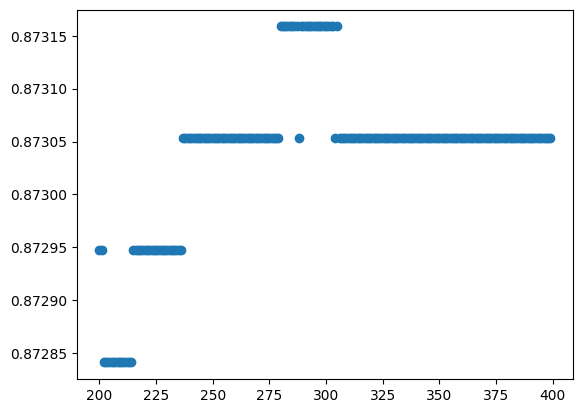

In [ ]:
# 'ID' : 0, 'IssueDateTime' : 1, 'DeclarationOfficeID' : 2, 'ProcessType' : 3, 'TransactionNature' : 4, 'Type' : 5 
# 'PaymentType' : 6, 'BorderTransportMeans' : 7, 'DeclarerID' : 8, 'ImporterID' : 9, 'SellerID' : 10
# 'ExpressID' : 11, 'ClassificationID' : 12, 'ExportationCountry' : 13, 'OriginCountry' : 14, 'TaxRate' : 15 
# 'DutyRegime' : 16, 'DisplayIndicator' : 17, 'TotalGrossMassMeasure(KG)' : 18, 'AdValoremTaxBaseAmount(Won)' : 19, 'Fake' : 20

test_data(pre_data, labels, [12, 15, 18], 200, 400)

feartures :ClassificationID  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 200 0.9072798558864046


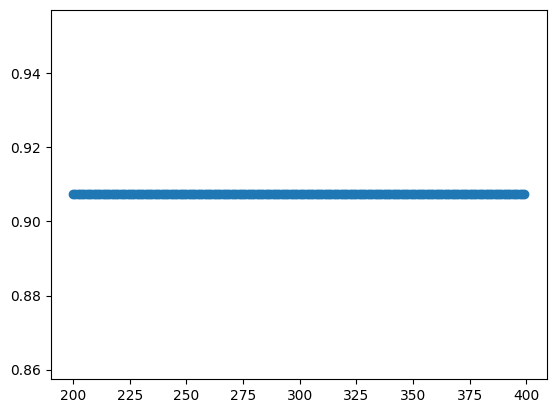

In [ ]:
# 'ID' : 0, 'IssueDateTime' : 1, 'DeclarationOfficeID' : 2, 'ProcessType' : 3, 'TransactionNature' : 4, 'Type' : 5 
# 'PaymentType' : 6, 'BorderTransportMeans' : 7, 'DeclarerID' : 8, 'ImporterID' : 9, 'SellerID' : 10
# 'ExpressID' : 11, 'ClassificationID' : 12, 'ExportationCountry' : 13, 'OriginCountry' : 14, 'TaxRate' : 15 
# 'DutyRegime' : 16, 'DisplayIndicator' : 17, 'TotalGrossMassMeasure(KG)' : 18, 'AdValoremTaxBaseAmount(Won)' : 19, 'Fake' : 20

test_data(pre_data, labels, [12, 15, 18, 19], 200, 400)

feartures :IssueDateTime  ClassificationID  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8501642471124298


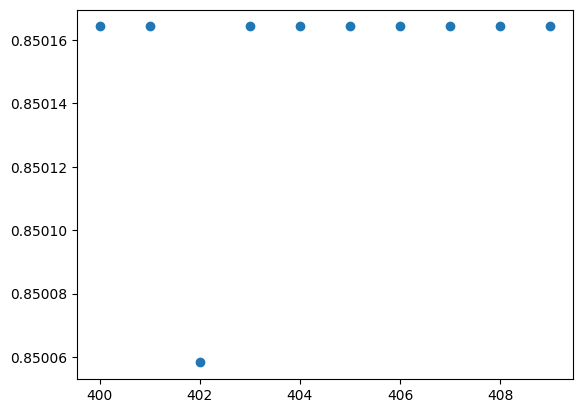

In [5]:
test_data(pre_data, labels, [1, 12, 18, 19], 400, 410)

feartures :ID  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 408 0.7835117092296281
feartures :IssueDateTime  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8517537352972343
feartures :DeclarationOfficeID  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8655292995655399
feartures :ProcessType  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.9060082653385609
feartures :TransactionNature  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8852389530571156
feartures :Type  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8958355409558122
feartures :PaymentType  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8770795803751192
feartures :BorderTransportMeans  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8862986118469852
feartures :DeclarerID  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmou

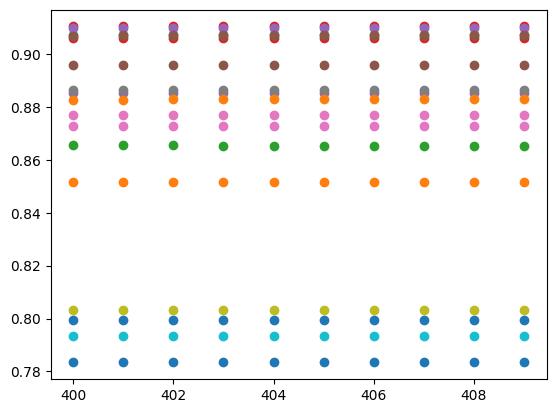

In [ ]:
test_data(pre_data, labels, [0, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [1, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [2, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [3, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [4, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [5, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [6, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [7, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [8, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [9, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [10, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [11, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [12, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [14, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [15, 16, 18, 19], 400, 410)
test_data(pre_data, labels, [15, 17, 18, 19], 400, 410)

feartures :ID  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 408 0.7835117092296281
feartures :IssueDateTime  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 404 0.8546148140298824
feartures :DeclarationOfficeID  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.868178446540214
feartures :ProcessType  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.9097170711031048
feartures :TransactionNature  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8878881000317898
feartures :Type  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8994383808413691
feartures :PaymentType  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8799406591077673
feartures :BorderTransportMeans  ExportationCountry  TaxRate  T

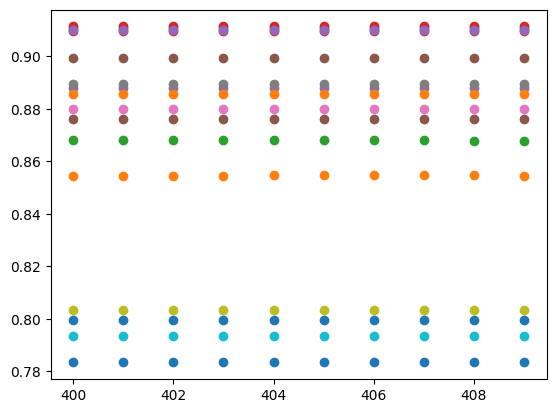

In [ ]:
# 'ID' : 0, 'IssueDateTime' : 1, 'DeclarationOfficeID' : 2, 'ProcessType' : 3, 'TransactionNature' : 4, 'Type' : 5 
# 'PaymentType' : 6, 'BorderTransportMeans' : 7, 'DeclarerID' : 8, 'ImporterID' : 9, 'SellerID' : 10
# 'ExpressID' : 11, 'ClassificationID' : 12, 'ExportationCountry' : 13, 'OriginCountry' : 14, 'TaxRate' : 15 
# 'DutyRegime' : 16, 'DisplayIndicator' : 17, 'TotalGrossMassMeasure(KG)' : 18, 'AdValoremTaxBaseAmount(Won)' : 19, 'Fake' : 20

test_data(pre_data, labels, [0, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [1, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [2, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [3, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [4, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [5, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [6, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [7, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [8, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [9, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [10, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [11, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [12, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [16, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [17, 13, 15, 18, 19], 400, 410)

feartures :ID  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 408 0.7835117092296281
feartures :IssueDateTime  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 405 0.8500582812334428
feartures :DeclarationOfficeID  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8642577090176963
feartures :ProcessType  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8994383808413691
feartures :TransactionNature  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8800466249867542
feartures :Type  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8914909399173466
feartures :PaymentType  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8737946381265232
feartures :BorderTransportMeans  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 405 0.8819540108085197
feartures :DeclarerID  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.802691533326269
feartures :ImporterID  TotalGrossMassMeasure(KG)

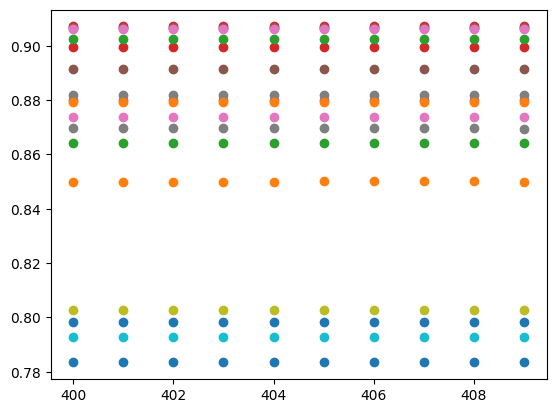

In [ ]:
test_data(pre_data, labels, [0, 18, 19], 400, 410)
test_data(pre_data, labels, [1, 18, 19], 400, 410)
test_data(pre_data, labels, [2, 18, 19], 400, 410)
test_data(pre_data, labels, [3, 18, 19], 400, 410)
test_data(pre_data, labels, [4, 18, 19], 400, 410)
test_data(pre_data, labels, [5, 18, 19], 400, 410)
test_data(pre_data, labels, [6, 18, 19], 400, 410)
test_data(pre_data, labels, [7, 18, 19], 400, 410)
test_data(pre_data, labels, [8, 18, 19], 400, 410)
test_data(pre_data, labels, [9, 18, 19], 400, 410)
test_data(pre_data, labels, [10, 18, 19], 400, 410)
test_data(pre_data, labels, [11, 18, 19], 400, 410)
test_data(pre_data, labels, [12, 18, 19], 400, 410)
test_data(pre_data, labels, [13, 18, 19], 400, 410)
test_data(pre_data, labels, [14, 18, 19], 400, 410)
test_data(pre_data, labels, [15, 18, 19], 400, 410)
test_data(pre_data, labels, [16, 18, 19], 400, 410)
test_data(pre_data, labels, [17, 18, 19], 400, 410)

feartures :IssueDateTime  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 404 0.855568506940765
feartures :DeclarationOfficeID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8688142418141358
feartures :ProcessType  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.9106707640139875
feartures :TransactionNature  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8885238953057115
feartures :Type  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.9004980396312388
feartures :PaymentType  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.88089435201865
feartures :BorderTransportMeans  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(K

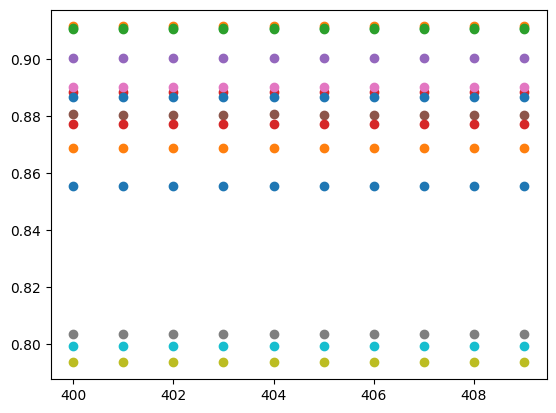

In [ ]:
test_data(pre_data, labels, [1, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [2, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [3, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [4, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [5, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [6, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [7, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [8, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [9, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [10, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [11, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [16, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [17, 14, 13, 15, 18, 19], 400, 410)

feartures :IssueDateTime  ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 401 0.855886404577726
feartures :DeclarationOfficeID  ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8689202076931228
feartures :ProcessType  ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.9107767298929744
feartures :TransactionNature  ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8885238953057115
feartures :Type  ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.9007099713892127
feartures :PaymentType  ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 400 0.8803645

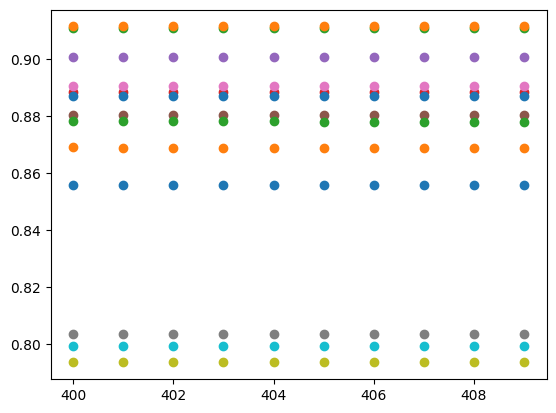

In [ ]:
test_data(pre_data, labels, [1, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [2, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [3, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [4, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [5, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [6, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [7, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [8, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [9, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [10, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [11, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [16, 12, 14, 13, 15, 18, 19], 400, 410)
test_data(pre_data, labels, [17, 12, 14, 13, 15, 18, 19], 400, 410)

In [ ]:
def test_data2(pre_data, labels, index, lower, upper, interval):
    data = make_data(pre_data, labels, index)
    data_input = data.to_numpy()
    data_target = pre_data['Fake'].to_numpy()

    train_input, test_input, train_target, test_target = train_test_split(data_input, data_target, random_state = 42)

    score = []
    indexs = []

    for i in range(lower, upper, interval):
        kn = KNeighborsClassifier(n_neighbors= i, weights = 'distance')
        scores = cross_validate(kn, train_input, train_target, return_train_score = True, n_jobs = -1)

        kn.fit(train_input, train_target)
        indexs.append(i)
        score.append(kn.score(test_input, test_target))

    print('feartures :', end = '')
    for j in range(len(index)):
        print(labels[index[j]], ' ', end = '')
    print('\n', lower + np.argmax(score), np.max(score))

    plt.scatter(indexs, score)
    return

feartures :ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 3000 0.9108826957719615
feartures :OriginCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 3000 0.9104588322560135
feartures :OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 3000 0.9118363886828441
feartures :ClassificationID  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 3000 0.9108826957719615
feartures :ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 3000 0.9118363886828441
feartures :DutyRegime  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 3000 0.9116244569248702
feartures :DutyRegime  ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)  
 3000 0.9118363886828441
feartures :Pr

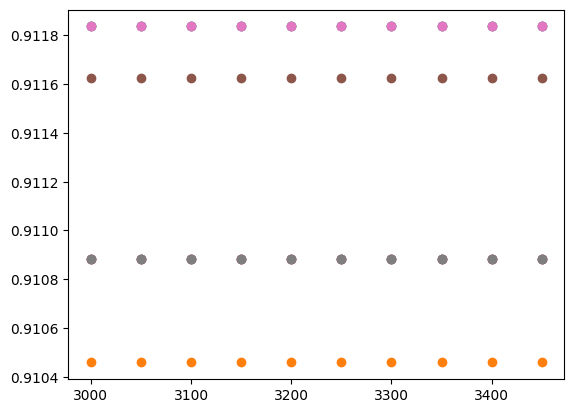

In [ ]:
# 'ID' : 0, 'IssueDateTime' : 1, 'DeclarationOfficeID' : 2, 'ProcessType' : 3, 'TransactionNature' : 4, 'Type' : 5 
# 'PaymentType' : 6, 'BorderTransportMeans' : 7, 'DeclarerID' : 8, 'ImporterID' : 9, 'SellerID' : 10
# 'ExpressID' : 11, 'ClassificationID' : 12, 'ExportationCountry' : 13, 'OriginCountry' : 14, 'TaxRate' : 15 
# 'DutyRegime' : 16, 'DisplayIndicator' : 17, 'TotalGrossMassMeasure(KG)' : 18, 'AdValoremTaxBaseAmount(Won)' : 19, 'Fake' : 20

#4 features
test_data2(pre_data, labels, [13, 15, 18, 19], 3000, 3500, 50)           #ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)
test_data2(pre_data, labels, [14, 15, 18, 19], 3000, 3500, 50)           #OriginCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)

#5 features
test_data2(pre_data, labels, [14, 13, 15, 18, 19], 3000, 3500, 50)       #OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)
test_data2(pre_data, labels, [12, 13, 15, 18, 19], 3000, 3500, 50)       #ClassificationID  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)

#6 features
test_data2(pre_data, labels, [12, 14, 13, 15, 18, 19], 3000, 3500, 50)    #ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)
test_data2(pre_data, labels, [16, 14, 13, 15, 18, 19], 3000, 3500, 50)    #DutyRegime  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)

#7 features
test_data2(pre_data, labels, [16, 12, 14, 13, 15, 18, 19], 3000, 3500, 50)#DutyRegime  ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)
test_data2(pre_data, labels, [3, 12, 14, 13, 15, 18, 19], 3000, 3500, 50) #ProcessType  ClassificationID  OriginCountry  ExportationCountry  TaxRate  TotalGrossMassMeasure(KG)  AdValoremTaxBaseAmount(Won)

In [ ]:
# 'ID' : 0, 'IssueDateTime' : 1, 'DeclarationOfficeID' : 2, 'ProcessType' : 3, 'TransactionNature' : 4, 'Type' : 5 
# 'PaymentType' : 6, 'BorderTransportMeans' : 7, 'DeclarerID' : 8, 'ImporterID' : 9, 'SellerID' : 10
# 'ExpressID' : 11, 'ClassificationID' : 12, 'ExportationCountry' : 13, 'OriginCountry' : 14, 'TaxRate' : 15 
# 'DutyRegime' : 16, 'DisplayIndicator' : 17, 'TotalGrossMassMeasure(KG)' : 18, 'AdValoremTaxBaseAmount(Won)' : 19

def make_test_data(pre_data, labels, index):
    for i in range(20):
        for j in range(len(index)):
            if i == index[j]:
                break
            if j == len(index)-1:
                pre_data = pre_data.drop(labels = labels[i], axis = 1)

    return pre_data.astype('float')


def make_prediction(pre_data, labels, index, neighbors):
    data = make_data(pre_data, labels, index)
    data_input = data.to_numpy()
    data_target = pre_data['Fake'].to_numpy()

    train_input, test_input, train_target, test_target = train_test_split(data_input, data_target, random_state = 42)

    kn = KNeighborsClassifier(n_neighbors = neighbors, weights = 'distance')
    scores = cross_validate(kn, train_input, train_target, return_train_score = True, n_jobs = -1)

    kn.fit(train_input, train_target)

    import_test = pd.read_csv('test.csv')
    pre_data2 = preprocess(import_test)
    test_data = make_test_data(pre_data2, labels, index)
    result = kn.predict(test_data)

    df = pd.DataFrame(result)

    df.to_csv('result.csv', index=False)

    return